# Lab5 testing various activation functions for regression and classification

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn import metrics
import math
import copy

# Implementacja sieci neurownowej:

In [2]:
class MLP:

    def __init__(self, layers, weights, biases, activation_function='sigmoid', output_function='softmax'):
        self.layers = layers
        self.weights = weights
        self.biases = biases

        self.d_w = []
        self.d_b = []
        
        if activation_function == 'sigmoid':
            self.activation_function = self.sigmoid
            self.activation_derivative = self.sigmoid_derivative
            
        elif activation_function == 'tanh':
            self.activation_function = self.tanh
            self.activation_derivative = self.tanh_derivative
            
        elif activation_function == 'ReLU':
            self.activation_function = self.ReLU
            self.activation_derivative = self.ReLU_derivative
            
        else:
            self.activation_function = self.linear
            self.activation_derivative = self.linear_derivative

        if output_function == 'softmax':
            self.output_function = self.softmax
        else:
            self.output_function = self.linear

    def forward_prop(self, inputs):
        """
        performs forward propagation
        """
        # activations and linear combinations passed to activation function
        self.a = []
        self.z = []

        activations = inputs
        self.a.append(activations)
        # propagate all but last layer with activaton function
        for i in range(len(self.layers) - 2):
            outputs = activations.dot(self.weights[i]) + self.biases[i]
            self.z.append(outputs)
            activations = self.activation_function(outputs)
            self.a.append(activations)

        # propagate last layer with output function
        results = activations.dot(self.weights[-1]) + self.biases[-1]
        self.z.append(results)
        activations = self.output_function(results)
        self.a.append(activations)
        return activations

    def backpropagation(self, y):
        """
        packpropagates error using activation functions derivatives
        """
        deltas = [None] * len(self.weights)

        # last delta
        if self.output_function == self.softmax:
            last_delta = []
            for val_a, val_y in zip(self.a[-1], y):
                err = val_y - val_a
                a = val_a.reshape(val_a.shape[0],)
                di_dj = - a * a.reshape(self.layers[-1], 1)
                d_d = np.diag(a) + di_dj
                last_delta.append(d_d.dot(err))
            last_delta = np.array(last_delta)
            deltas[-1] = copy.deepcopy(last_delta)
            
        elif self.output_function == self.linear:
            deltas[-1] = y - self.a[-1]

        # previous deltas
        for i in reversed(range(len(deltas) - 1)):
            deltas[i] = ((self.weights[i + 1].dot(deltas[i + 1].T)) * self.activation_derivative(self.z[i]).T).T

        # calculate derivatives
        d_b = [None] * len(deltas)
        d_w = [None] * len(deltas)
        for i, d in enumerate(deltas):
            d_w[i] = (d.T.dot(self.a[i])).T / y.shape[0]
            d_b[i] = (d.T.dot(np.ones((y.shape[0], 1)))).T / y.shape[0]

        return d_w, d_b

    def train(self, x, y, batch_size=20, epochs=500, lr=0.1):
        """
        trains neural network
        """
        # encode target for classification
        if self.output_function == self.softmax:
            encode = np.zeros((y.size, y.max() + 1))
            encode[np.arange(y.size), y.flatten()] = 1
            y = encode

        # randmize observations' order
        p = np.random.permutation(len(y))
        x = x[p]
        y = y[p]

        for epoch in range(epochs):
            i = 0
            while i < len(y):
                x_batch = x[i:i + batch_size]
                y_batch = y[i:i + batch_size]
                i = i + batch_size
                self.forward_prop(x_batch)
                
                # backpropagate
                d_w, d_b = self.backpropagation(y_batch)

                # gradient descent
                self.weights = [w + lr * dweight for w, dweight in zip(self.weights, d_w)]
                self.bias = [b + lr * dbias for b, dbias in zip(self.biases, d_b)]
                
            # print error
            if self.output_function == self.softmax:
                if epoch % 500 == 0 or epoch == epochs-1:
                    print("Epoch: {: <5} Cross entropy loss: {}".
                          format(epoch, metrics.log_loss(np.argmax(y_batch, axis=1), self.a[-1])))
            else:
                if epoch % 500 == 0 or epoch == epochs-1:
                    print("Epoch: {: <5} Mean absolute error: {}".format(epoch,np.abs(y_batch - self.a[-1]).mean()))
                
    @staticmethod
    def softmax(x):
        e_x = np.exp(x.T - np.max(x, axis=1).T).T
        return (e_x.T / e_x.sum(axis=1).T).T

    @staticmethod
    def linear(x): 
        return(x)
    
    @staticmethod
    def linear_derivative(x): 
        return np.ones(x.shape[0]*x.shape[1]).reshape(x.shape[0], x.shape[1])
    
    @staticmethod
    def sigmoid(x):
        return np.exp(x) / (1 + np.exp(x))

    @staticmethod
    def sigmoid_derivative(x):
        def sigmoid(x):
            return np.exp(x) / (1 + np.exp(x))
        return sigmoid(x) * (1 - sigmoid(x))
    
    @staticmethod
    def tanh(x): 
        return np.tanh(x)
    
    @staticmethod
    def tanh_derivative(x): 
        return 1 - np.tanh(x)**2
    
    @staticmethod
    def ReLU(x):
        return x * (x > 0)

    @staticmethod
    def ReLU_derivative(x):
        return 1. * (x > 0)

    def show_attributes(self):
        """
        gives basic information about the neural network
        """
        print("Neural Network attributes:")
        print("-------------------------")
        print("Number of neurons in layers: {}".format(self.layers))
        print("Activation function used: {}".format(self.activation_function))
        print("Output activation function used: {}".format(self.output_function))
        return



def generate_random_mlp(layers, activation_function ='sigmoid', output_function='softmax', start=-1, stop=1):
    """
    generates mlp with random weights given number of neurons in each layer and activation functions
    """
    weights = []
    biases = []

    for i in range(len(layers) - 1):
        weights.append(np.random.uniform(start, stop, layers[i] * layers[i + 1]).reshape(layers[i], layers[i + 1]))
        biases.append(np.random.uniform(start, stop, layers[i + 1]).reshape(1, layers[i+1]))
    mlp = MLP(layers, weights, biases, activation_function=activation_function, output_function=output_function)
    return mlp

Jako funckję aktwyacji przetestowane będą:
    - sigmoid
    - liniowa
    - tanh
    - ReLU
Zakładamy, że wartością pochodnej funckcji ReLU w punkcie 0 jest 0.

Jako funkcję na wyjściu przyjmiemy:
    - liniową, dla zadań regresji
    - softmax, dla zadań klasyfikacji
Przebadamy architektury dla regresji:
    - z jedną warstwą ukrytą z 5 neuronami, liczbą epok = 3000
    - z dwoma warstwami ukrytymi z 12 i 20 neuronami, liczbą epok = 2000
    - z trzema warstwami ukrytymi z 12,16 i 12 neuronami, liczbą epok = 1500
Natomiast dla klasyfikacji:
    - z jedną warstwą ukrytą z 100 neuronami, liczbą epok = 3000
    - z dwoma warstwami ukrytymi z 100 neuronami każda, liczbą epok = 2000
    - z trzema warstwami ukrytymi z 100 neuronami każda, liczbą epok = 1500
W obrębie jednego zbioru, wielkość batcha oraz krok uczenia będą stała.

# 1. Regresja: steps-large

In [3]:
train_df = pd.read_csv('~/Documents/Sem6/MIO/datasets/regression/steps-large-training.csv',index_col=0)
test_df = pd.read_csv('~/Documents/Sem6/MIO/datasets/regression/steps-large-test.csv',index_col=0)
train_df.iloc[0:6,:]

x   y
1 -1.481354 -80
2  1.033264  80
3 -0.076403   0
4 -1.419785 -80
5 -0.108398   0
6 -0.878623 -80

Text(0.5, 1.0, 'Train split')

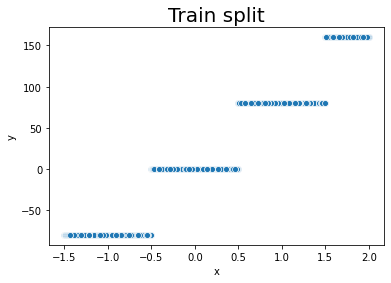

In [4]:
sns.scatterplot(x='x', y='y', data=train_df)
plt.title('Train split', fontsize=20)

In [5]:
x_train = np.asarray([train_df.iloc[:,0]]).T
y_train = np.asarray([train_df.iloc[:,1]]).T
x_test = np.asarray([test_df.iloc[:,0]]).T
y_test = np.asarray([test_df.iloc[:,1]]).T

## 1.1 jedna warstwa ukryta

### 1.1.1 jedna warstwa ukryta - sigmoid

Epoch: 0     Mean absolute error: 73.65087919001265
Epoch: 500   Mean absolute error: 22.365257592464523
Epoch: 1000  Mean absolute error: 17.92748640865962
Epoch: 1500  Mean absolute error: 17.18057226024338
Epoch: 2000  Mean absolute error: 16.727656164681516
Epoch: 2500  Mean absolute error: 16.39972799783466
Epoch: 2999  Mean absolute error: 16.187155902851234


Text(0.5, 1.0, 'Test performance - sigmoid')

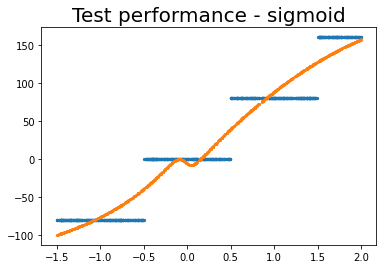

In [6]:
mymlp = generate_random_mlp([1,10,1], activation_function='sigmoid', output_function='linear')
mymlp.train(x_train, y_train, batch_size=128, epochs=3000, lr=0.0005)

result_sigmoid = mymlp.forward_prop(x_test)

plt.scatter(x=x_test, y=y_test, s=5)
plt.scatter(x=x_test, y=np.concatenate(result_sigmoid), s=3)
plt.title('Test performance - sigmoid', fontsize=20)

### 1.1.2 jedna warstwa ukryta - linear

Epoch: 0     Mean absolute error: 21.630916427618665
Epoch: 500   Mean absolute error: 21.354122362822643
Epoch: 1000  Mean absolute error: 21.354120005980093
Epoch: 1500  Mean absolute error: 21.354117810519618
Epoch: 2000  Mean absolute error: 21.354115765600216
Epoch: 2500  Mean absolute error: 21.354113861148747
Epoch: 2999  Mean absolute error: 21.354112091224216


Text(0.5, 1.0, 'Test performance - linear')

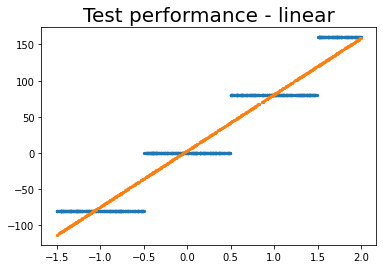

In [7]:
mymlp = generate_random_mlp([1,10,1], activation_function='linear', output_function='linear')
mymlp.train(x_train, y_train, batch_size=128, epochs=3000, lr=0.0005)

result_linear = mymlp.forward_prop(x_test)

plt.scatter(x=x_test, y=y_test, s=5)
plt.scatter(x=x_test, y=np.concatenate(result_linear), s=3)
plt.title('Test performance - linear', fontsize=20)

### 1.1.3 jedna warstwa ukryta - tanh

Epoch: 0     Mean absolute error: 58.31131285124157
Epoch: 500   Mean absolute error: 19.609547956075428
Epoch: 1000  Mean absolute error: 19.653574804772425
Epoch: 1500  Mean absolute error: 19.716826923037736
Epoch: 2000  Mean absolute error: 19.75160598941709
Epoch: 2500  Mean absolute error: 19.76670526131807
Epoch: 2999  Mean absolute error: 19.775289579654277


Text(0.5, 1.0, 'Test performance - tanh')

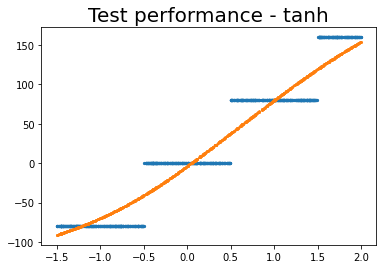

In [8]:
mymlp = generate_random_mlp([1,10,1], activation_function='tanh', output_function='linear')
mymlp.train(x_train, y_train, batch_size=128, epochs=3000, lr=0.0005)

result_tanh = mymlp.forward_prop(x_test)

plt.scatter(x=x_test, y=y_test, s=5)
plt.scatter(x=x_test, y=np.concatenate(result_tanh), s=3)
plt.title('Test performance - tanh', fontsize=20)

### 1.1.4 jedna warstwa ukryta - ReLU

Epoch: 0     Mean absolute error: 51.34885422256378
Epoch: 500   Mean absolute error: 22.8860421741295
Epoch: 1000  Mean absolute error: 22.815296193111514
Epoch: 1500  Mean absolute error: 22.792869071005782
Epoch: 2000  Mean absolute error: 22.806216313958664
Epoch: 2500  Mean absolute error: 22.83397935421563
Epoch: 2999  Mean absolute error: 22.863262821641204


Text(0.5, 1.0, 'Test performance')

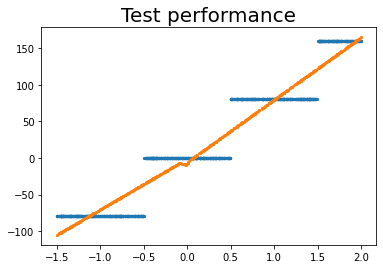

In [9]:
mymlp = generate_random_mlp([1,10,1], activation_function='ReLU', output_function='linear')
mymlp.train(x_train, y_train, batch_size=128, epochs=3000, lr=0.0005)

result_relu = mymlp.forward_prop(x_test)

plt.scatter(x=x_test, y=y_test, s=5)
plt.scatter(x=x_test, y=np.concatenate(result_relu), s=3)
plt.title('Test performance', fontsize=20)

### 1.1.5 Podsumowanie zbioru - jedna warstwa ukryta

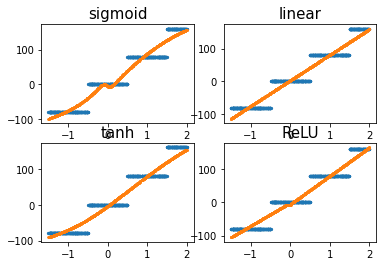

In [10]:
fig = plt.figure()

plt.subplot(2, 2, 1)
plt.scatter(x=x_test, y=y_test, s=5)
plt.scatter(x=x_test, y=np.concatenate(result_sigmoid), s=3)
plt.title('sigmoid', fontsize=15)

plt.subplot(2, 2, 2)
plt.scatter(x=x_test, y=y_test, s=5)
plt.scatter(x=x_test, y=np.concatenate(result_linear), s=3)
plt.title('linear', fontsize=15)

plt.subplot(2, 2, 3)
plt.scatter(x=x_test, y=y_test, s=5)
plt.scatter(x=x_test, y=np.concatenate(result_tanh), s=3)
plt.title('tanh', fontsize=15)

plt.subplot(2, 2, 4)
plt.scatter(x=x_test, y=y_test, s=5)
plt.scatter(x=x_test, y=np.concatenate(result_relu), s=3)
plt.title('ReLU', fontsize=15)

plt.show()

W tym przypadku żadna funkcja nie dopaswoła się znacznie lepiej od liniowej.

## 1.2 dwie warstwy ukryte

### 1.2.1 dwie warstwy ukryte - sigmoid

Epoch: 0     Mean absolute error: 66.03156728538102
Epoch: 500   Mean absolute error: 5.440623439744739
Epoch: 1000  Mean absolute error: 3.9618163390521492
Epoch: 1500  Mean absolute error: 3.1943974818932994
Epoch: 1999  Mean absolute error: 2.678365086835563


Text(0.5, 1.0, 'Test performance - sigmoid')

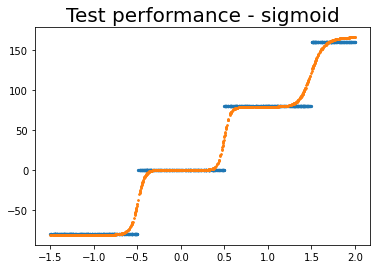

In [11]:
mymlp = generate_random_mlp([1,12,20,1], activation_function='sigmoid', output_function='linear')
mymlp.train(x_train, y_train, batch_size=128, epochs=2000, lr=0.0005)

result_sigmoid = mymlp.forward_prop(x_test)

plt.scatter(x=x_test, y=y_test, s=5)
plt.scatter(x=x_test, y=np.concatenate(result_sigmoid), s=3)
plt.title('Test performance - sigmoid', fontsize=20)

### 1.2.2 dwie warstwy ukryte - linear

Epoch: 0     Mean absolute error: 18.735771901407915
Epoch: 500   Mean absolute error: 18.742116000956464
Epoch: 1000  Mean absolute error: 18.743586598502514
Epoch: 1500  Mean absolute error: 18.74478721373868
Epoch: 1999  Mean absolute error: 18.74580841567284


Text(0.5, 1.0, 'Test performance - linear')

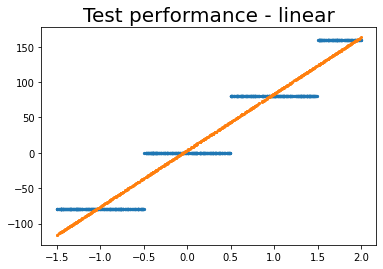

In [12]:
mymlp = generate_random_mlp([1,12,20,1], activation_function='linear', output_function='linear')
mymlp.train(x_train, y_train, batch_size=128, epochs=2000, lr=0.0005)

result_linear = mymlp.forward_prop(x_test)

plt.scatter(x=x_test, y=y_test, s=5)
plt.scatter(x=x_test, y=np.concatenate(result_linear), s=3)
plt.title('Test performance - linear', fontsize=20)

### 1.2.3 dwie warstwy ukryte - tanh

Epoch: 0     Mean absolute error: 52.227481896790195
Epoch: 500   Mean absolute error: 3.709241558094722
Epoch: 1000  Mean absolute error: 3.2418557718166614
Epoch: 1500  Mean absolute error: 2.9636241079489283
Epoch: 1999  Mean absolute error: 2.734594261677585


Text(0.5, 1.0, 'Test performance - tanh')

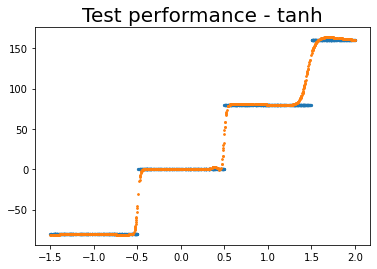

In [13]:
mymlp = generate_random_mlp([1,12,20,1], activation_function='tanh', output_function='linear')
mymlp.train(x_train, y_train, batch_size=128, epochs=2000, lr=0.0005)

result_tanh = mymlp.forward_prop(x_test)

plt.scatter(x=x_test, y=y_test, s=5)
plt.scatter(x=x_test, y=np.concatenate(result_tanh), s=3)
plt.title('Test performance - tanh', fontsize=20)

### 1.2.4 dwie warstwy ukryte - ReLU

Epoch: 0     Mean absolute error: 21.501034154737354
Epoch: 500   Mean absolute error: 12.890468540257737
Epoch: 1000  Mean absolute error: 7.630160729269342
Epoch: 1500  Mean absolute error: 7.283212748762024
Epoch: 1999  Mean absolute error: 8.3941264963279


Text(0.5, 1.0, 'Test performance')

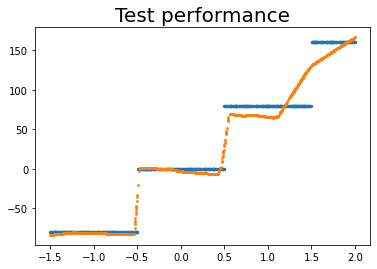

In [14]:
mymlp = generate_random_mlp([1,12,20,1], activation_function='ReLU', output_function='linear')
mymlp.train(x_train, y_train, batch_size=128, epochs=2000, lr=0.0005)

result_relu = mymlp.forward_prop(x_test)

plt.scatter(x=x_test, y=y_test, s=5)
plt.scatter(x=x_test, y=np.concatenate(result_relu), s=3)
plt.title('Test performance', fontsize=20)

### 1.2.5 Podsumowanie zbioru - dwie warstwy ukryte

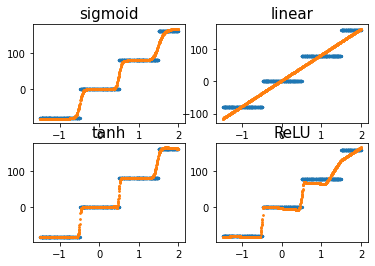

In [15]:
fig = plt.figure()

plt.subplot(2, 2, 1)
plt.scatter(x=x_test, y=y_test, s=5)
plt.scatter(x=x_test, y=np.concatenate(result_sigmoid), s=3)
plt.title('sigmoid', fontsize=15)

plt.subplot(2, 2, 2)
plt.scatter(x=x_test, y=y_test, s=5)
plt.scatter(x=x_test, y=np.concatenate(result_linear), s=3)
plt.title('linear', fontsize=15)

plt.subplot(2, 2, 3)
plt.scatter(x=x_test, y=y_test, s=5)
plt.scatter(x=x_test, y=np.concatenate(result_tanh), s=3)
plt.title('tanh', fontsize=15)

plt.subplot(2, 2, 4)
plt.scatter(x=x_test, y=y_test, s=5)
plt.scatter(x=x_test, y=np.concatenate(result_relu), s=3)
plt.title('ReLU', fontsize=15)

plt.show()

Najlepiej radzą sobie sigmoid oraz tanh, ReLU trochę gorzej dla dużych wartości x. Funkcja liniowa natomiast jest bardzo blisko najlepiej dopasowującej się prostej, dla tej funkcji jednak nie możemy spodziewać się lepszego wyniku. 

## 1.3 trzy warstwy ukryte

### 1.3.1 trzy warstwy ukryte - sigmoid

Epoch: 0     Mean absolute error: 65.40968278685118
Epoch: 500   Mean absolute error: 0.8250340421044082
Epoch: 1000  Mean absolute error: 0.6113116318461465
Epoch: 1499  Mean absolute error: 0.5555746897990679


Text(0.5, 1.0, 'Test performance - sigmoid')

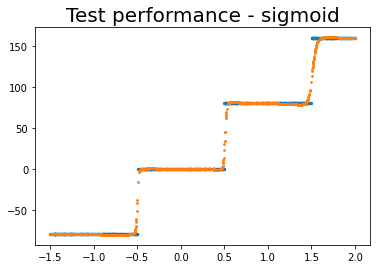

In [16]:
mymlp = generate_random_mlp([1,12,16,12,1], activation_function='sigmoid', output_function='linear')
mymlp.train(x_train, y_train, batch_size=128, epochs=1500, lr=0.0005)

result_sigmoid = mymlp.forward_prop(x_test)

plt.scatter(x=x_test, y=y_test, s=5)
plt.scatter(x=x_test, y=np.concatenate(result_sigmoid), s=3)
plt.title('Test performance - sigmoid', fontsize=20)

###  1.3.2 trzy warstwy ukryte - linear

Epoch: 0     Mean absolute error: 16.34962958362894
Epoch: 500   Mean absolute error: 16.859696638083477
Epoch: 1000  Mean absolute error: 16.930131565204512
Epoch: 1499  Mean absolute error: 16.978853409668773


Text(0.5, 1.0, 'Test performance - linear')

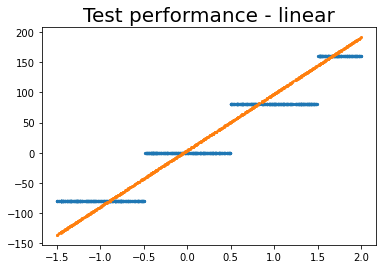

In [17]:
mymlp = generate_random_mlp([1,12,16,12,1], activation_function='linear', output_function='linear')
mymlp.train(x_train, y_train, batch_size=128, epochs=1500, lr=0.0005)

result_linear = mymlp.forward_prop(x_test)

plt.scatter(x=x_test, y=y_test, s=5)
plt.scatter(x=x_test, y=np.concatenate(result_linear), s=3)
plt.title('Test performance - linear', fontsize=20)

###  1.3.3 trzy warstwy ukryte - tanh

Epoch: 0     Mean absolute error: 45.380104169806
Epoch: 500   Mean absolute error: 0.5743246155176501
Epoch: 1000  Mean absolute error: 0.25770682545396806
Epoch: 1499  Mean absolute error: 0.19471759336264494


Text(0.5, 1.0, 'Test performance - tanh')

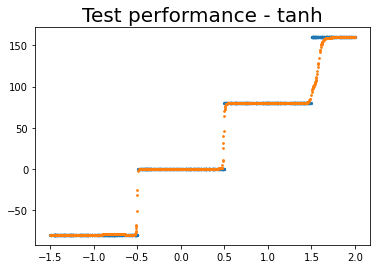

In [18]:
mymlp = generate_random_mlp([1,12,16,12,1], activation_function='tanh', output_function='linear')
mymlp.train(x_train, y_train, batch_size=128, epochs=1500, lr=0.0005)

result_tanh = mymlp.forward_prop(x_test)

plt.scatter(x=x_test, y=y_test, s=5)
plt.scatter(x=x_test, y=np.concatenate(result_tanh), s=3)
plt.title('Test performance - tanh', fontsize=20)

###  1.3.4 trzy warstwy ukryte - ReLU

Epoch: 0     Mean absolute error: 18.718399470069063
Epoch: 500   Mean absolute error: 7.637477414827412
Epoch: 1000  Mean absolute error: 6.280689627406326
Epoch: 1499  Mean absolute error: 76.59586987643753


Text(0.5, 1.0, 'Test performance')

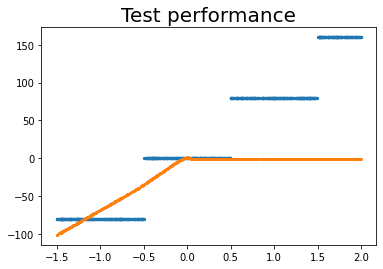

In [19]:
mymlp = generate_random_mlp([1,12,16,12,1], activation_function='ReLU', output_function='linear')
mymlp.train(x_train, y_train, batch_size=128, epochs=1500, lr=0.0005)

result_relu = mymlp.forward_prop(x_test)

plt.scatter(x=x_test, y=y_test, s=5)
plt.scatter(x=x_test, y=np.concatenate(result_relu), s=3)
plt.title('Test performance', fontsize=20)

### 1.3.5 Podsumowanie zbioru - trzy warstwy ukryte

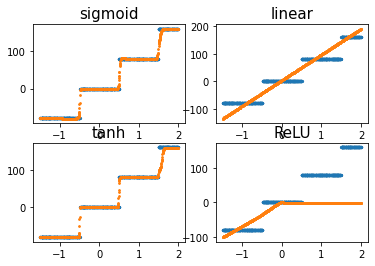

In [20]:
fig = plt.figure()

plt.subplot(2, 2, 1)
plt.scatter(x=x_test, y=y_test, s=5)
plt.scatter(x=x_test, y=np.concatenate(result_sigmoid), s=3)
plt.title('sigmoid', fontsize=15)

plt.subplot(2, 2, 2)
plt.scatter(x=x_test, y=y_test, s=5)
plt.scatter(x=x_test, y=np.concatenate(result_linear), s=3)
plt.title('linear', fontsize=15)

plt.subplot(2, 2, 3)
plt.scatter(x=x_test, y=y_test, s=5)
plt.scatter(x=x_test, y=np.concatenate(result_tanh), s=3)
plt.title('tanh', fontsize=15)

plt.subplot(2, 2, 4)
plt.scatter(x=x_test, y=y_test, s=5)
plt.scatter(x=x_test, y=np.concatenate(result_relu), s=3)
plt.title('ReLU', fontsize=15)

plt.show()

Podobnie jak wyżej, najlepiej poradził sobie sigmoid, później tanh. ReLU w tym przypadku pomiędzy 1000 a 1500 epoką bardzo się pogorszyła (średnia wartość bezwzględna błędu zwiększyła się z 6.28 na 77). Jest to zaskakujący wynik, w żadnym innym przypadku tak się nie stało.

# 2. Regresja: multimodal-large

In [21]:
train_df = pd.read_csv('~/Documents/Sem6/MIO/datasets/regression/multimodal-large-training.csv',index_col=0)
test_df = pd.read_csv('~/Documents/Sem6/MIO/datasets/regression/multimodal-large-test.csv',index_col=0)
train_df.iloc[0:6,:]

x    y
1 -0.685726  -80
2 -0.879898  -80
3  1.411932   80
4  1.688954  160
5 -0.573238  -80
6 -0.316174    0

Text(0.5, 1.0, 'Train split')

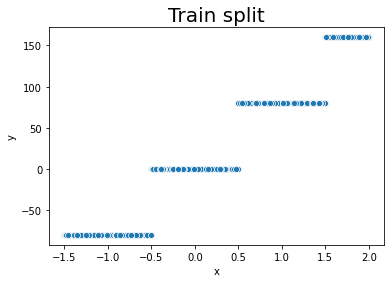

In [22]:
sns.scatterplot(x='x', y='y', data=train_df)
plt.title('Train split', fontsize=20)

In [23]:
x_train = np.asarray([train_df.iloc[:,0]]).T
y_train = np.asarray([train_df.iloc[:,1]]).T
x_test = np.asarray([test_df.iloc[:,0]]).T
y_test = np.asarray([test_df.iloc[:,1]]).T

## 2.1 jedna warstwa ukryta

### 2.1.1 jedna warstwa ukryta - sigmoid

Epoch: 0     Mean absolute error: 69.46110917890611
Epoch: 500   Mean absolute error: 19.908530711552885
Epoch: 1000  Mean absolute error: 18.35502921046603
Epoch: 1500  Mean absolute error: 17.704503402939864
Epoch: 2000  Mean absolute error: 17.342371254334516
Epoch: 2500  Mean absolute error: 17.090000231149766
Epoch: 2999  Mean absolute error: 16.902093284320323


Text(0.5, 1.0, 'Test performance - sigmoid')

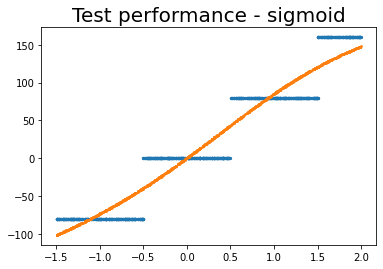

In [24]:
mymlp = generate_random_mlp([1,10,1], activation_function='sigmoid', output_function='linear')
mymlp.train(x_train, y_train, batch_size=128, epochs=3000, lr=0.0005)

result_sigmoid = mymlp.forward_prop(x_test)

plt.scatter(x=x_test, y=y_test, s=5)
plt.scatter(x=x_test, y=np.concatenate(result_sigmoid), s=3)
plt.title('Test performance - sigmoid', fontsize=20)

### 2.1.2 jedna warstwa ukryta - linear

Epoch: 0     Mean absolute error: 22.309645318955162
Epoch: 500   Mean absolute error: 19.25632260517041
Epoch: 1000  Mean absolute error: 19.25634475591591
Epoch: 1500  Mean absolute error: 19.25636624012308
Epoch: 2000  Mean absolute error: 19.256387080839716
Epoch: 2500  Mean absolute error: 19.256407300183312
Epoch: 2999  Mean absolute error: 19.25642688073247


Text(0.5, 1.0, 'Test performance - linear')

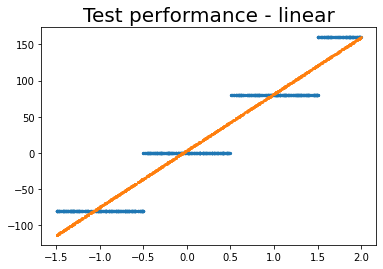

In [25]:
mymlp = generate_random_mlp([1,10,1], activation_function='linear', output_function='linear')
mymlp.train(x_train, y_train, batch_size=128, epochs=3000, lr=0.0005)

result_linear = mymlp.forward_prop(x_test)

plt.scatter(x=x_test, y=y_test, s=5)
plt.scatter(x=x_test, y=np.concatenate(result_linear), s=3)
plt.title('Test performance - linear', fontsize=20)

### 2.1.3 jedna warstwa ukryta - tanh

Epoch: 0     Mean absolute error: 65.38755587712008
Epoch: 500   Mean absolute error: 22.84185973915875
Epoch: 1000  Mean absolute error: 22.496267871210485
Epoch: 1500  Mean absolute error: 22.503909571263957
Epoch: 2000  Mean absolute error: 22.494650280478773
Epoch: 2500  Mean absolute error: 22.47914494249115
Epoch: 2999  Mean absolute error: 22.464044607199206


Text(0.5, 1.0, 'Test performance - tanh')

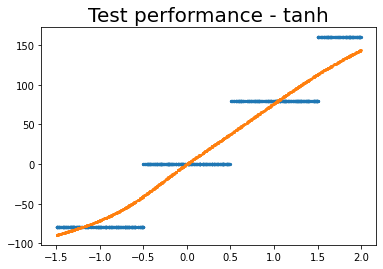

In [26]:
mymlp = generate_random_mlp([1,10,1], activation_function='tanh', output_function='linear')
mymlp.train(x_train, y_train, batch_size=128, epochs=3000, lr=0.0005)

result_tanh = mymlp.forward_prop(x_test)

plt.scatter(x=x_test, y=y_test, s=5)
plt.scatter(x=x_test, y=np.concatenate(result_tanh), s=3)
plt.title('Test performance - tanh', fontsize=20)

### 2.1.4 jedna warstwa ukryta - ReLU

Epoch: 0     Mean absolute error: 41.893580013134766
Epoch: 500   Mean absolute error: 15.96086221700487
Epoch: 1000  Mean absolute error: 15.881680184696105
Epoch: 1500  Mean absolute error: 15.731826076889371
Epoch: 2000  Mean absolute error: 15.583111504092809
Epoch: 2500  Mean absolute error: 15.44793001432086
Epoch: 2999  Mean absolute error: 15.324396536985281


Text(0.5, 1.0, 'Test performance')

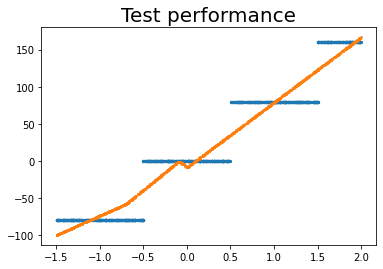

In [27]:
mymlp = generate_random_mlp([1,10,1], activation_function='ReLU', output_function='linear')
mymlp.train(x_train, y_train, batch_size=128, epochs=3000, lr=0.0005)

result_relu = mymlp.forward_prop(x_test)

plt.scatter(x=x_test, y=y_test, s=5)
plt.scatter(x=x_test, y=np.concatenate(result_relu), s=3)
plt.title('Test performance', fontsize=20)

### 2.1.5 podsumowanie zbioru - jedna warstwa ukryta

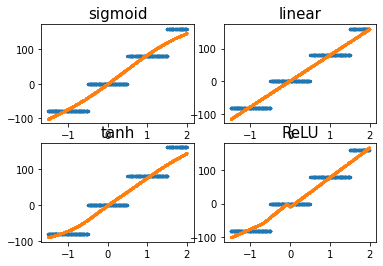

In [28]:
fig = plt.figure()

plt.subplot(2, 2, 1)
plt.scatter(x=x_test, y=y_test, s=5)
plt.scatter(x=x_test, y=np.concatenate(result_sigmoid), s=3)
plt.title('sigmoid', fontsize=15)

plt.subplot(2, 2, 2)
plt.scatter(x=x_test, y=y_test, s=5)
plt.scatter(x=x_test, y=np.concatenate(result_linear), s=3)
plt.title('linear', fontsize=15)

plt.subplot(2, 2, 3)
plt.scatter(x=x_test, y=y_test, s=5)
plt.scatter(x=x_test, y=np.concatenate(result_tanh), s=3)
plt.title('tanh', fontsize=15)

plt.subplot(2, 2, 4)
plt.scatter(x=x_test, y=y_test, s=5)
plt.scatter(x=x_test, y=np.concatenate(result_relu), s=3)
plt.title('ReLU', fontsize=15)

plt.show()

Tutaj żadnej funkcji nie udało się znacząco poprawić wyniku funkcji liniowej.

## 2.2 dwie warstwy ukryte

### 2.2.1 dwie warstwy ukryte - sigmoid

Epoch: 0     Mean absolute error: 65.44636392444994
Epoch: 500   Mean absolute error: 5.544686523289984
Epoch: 1000  Mean absolute error: 4.472822738623705
Epoch: 1500  Mean absolute error: 3.780269802978091
Epoch: 1999  Mean absolute error: 3.3362865236690147


Text(0.5, 1.0, 'Test performance - sigmoid')

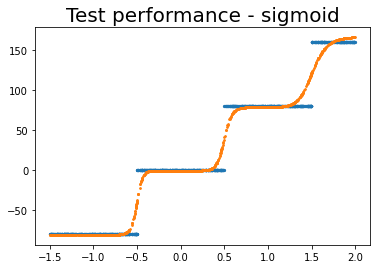

In [29]:
mymlp = generate_random_mlp([1,12,20,1], activation_function='sigmoid', output_function='linear')
mymlp.train(x_train, y_train, batch_size=128, epochs=2000, lr=0.0005)

result_sigmoid = mymlp.forward_prop(x_test)

plt.scatter(x=x_test, y=y_test, s=5)
plt.scatter(x=x_test, y=np.concatenate(result_sigmoid), s=3)
plt.title('Test performance - sigmoid', fontsize=20)

### 2.2.2 dwie warstwy ukryte - linear

Epoch: 0     Mean absolute error: 20.348196014109767
Epoch: 500   Mean absolute error: 20.39982858884119
Epoch: 1000  Mean absolute error: 20.40351539376742
Epoch: 1500  Mean absolute error: 20.405091356408935
Epoch: 1999  Mean absolute error: 20.406119325835213


Text(0.5, 1.0, 'Test performance - linear')

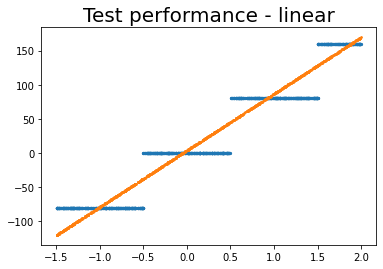

In [30]:
mymlp = generate_random_mlp([1,12,20,1], activation_function='linear', output_function='linear')
mymlp.train(x_train, y_train, batch_size=128, epochs=2000, lr=0.0005)

result_linear = mymlp.forward_prop(x_test)

plt.scatter(x=x_test, y=y_test, s=5)
plt.scatter(x=x_test, y=np.concatenate(result_linear), s=3)
plt.title('Test performance - linear', fontsize=20)

### 2.2.3 dwie warstwy ukryte - tanh

Epoch: 0     Mean absolute error: 53.40066351057803
Epoch: 500   Mean absolute error: 4.851662243935998
Epoch: 1000  Mean absolute error: 4.390453535069147
Epoch: 1500  Mean absolute error: 4.122006900706543
Epoch: 2000  Mean absolute error: 3.941673595591552
Epoch: 2500  Mean absolute error: 3.8041426880524933
Epoch: 2999  Mean absolute error: 3.686407844252833


Text(0.5, 1.0, 'Test performance - tanh')

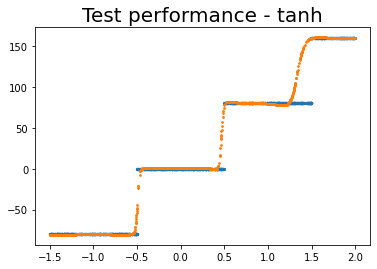

In [31]:
mymlp = generate_random_mlp([1,12,20,1], activation_function='tanh', output_function='linear')
mymlp.train(x_train, y_train, batch_size=128, epochs=2000, lr=0.0005)

result_tanh = mymlp.forward_prop(x_test)

plt.scatter(x=x_test, y=y_test, s=5)
plt.scatter(x=x_test, y=np.concatenate(result_tanh), s=3)
plt.title('Test performance - tanh', fontsize=20)

### 2.2.4 dwie warstwy ukryte - ReLU

Epoch: 0     Mean absolute error: 16.76145946947978
Epoch: 500   Mean absolute error: 8.501520602471484
Epoch: 1000  Mean absolute error: 9.607425299400823
Epoch: 1500  Mean absolute error: 6.967476147018823
Epoch: 1999  Mean absolute error: 9.931931481631787


Text(0.5, 1.0, 'Test performance')

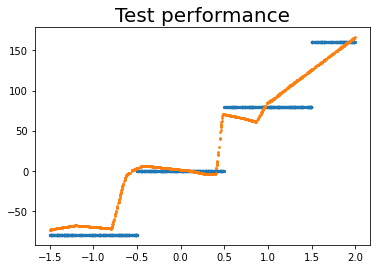

In [32]:
mymlp = generate_random_mlp([1,12,20,1], activation_function='ReLU', output_function='linear')
mymlp.train(x_train, y_train, batch_size=128, epochs=2000, lr=0.0005)

result_relu = mymlp.forward_prop(x_test)

plt.scatter(x=x_test, y=y_test, s=5)
plt.scatter(x=x_test, y=np.concatenate(result_relu), s=3)
plt.title('Test performance', fontsize=20)

### 2.2.5 podsumowanie zbioru - dwie warstwy ukryte

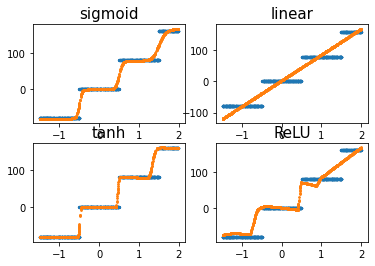

In [33]:
fig = plt.figure()

plt.subplot(2, 2, 1)
plt.scatter(x=x_test, y=y_test, s=5)
plt.scatter(x=x_test, y=np.concatenate(result_sigmoid), s=3)
plt.title('sigmoid', fontsize=15)

plt.subplot(2, 2, 2)
plt.scatter(x=x_test, y=y_test, s=5)
plt.scatter(x=x_test, y=np.concatenate(result_linear), s=3)
plt.title('linear', fontsize=15)

plt.subplot(2, 2, 3)
plt.scatter(x=x_test, y=y_test, s=5)
plt.scatter(x=x_test, y=np.concatenate(result_tanh), s=3)
plt.title('tanh', fontsize=15)

plt.subplot(2, 2, 4)
plt.scatter(x=x_test, y=y_test, s=5)
plt.scatter(x=x_test, y=np.concatenate(result_relu), s=3)
plt.title('ReLU', fontsize=15)

plt.show()

Podobnie jak w poprzedznich przypadkach, najlepiej poradziły sobie sigmoid i tanh, za nimi natomiast ReLU.

## 2.3 trzy warstwy ukryte

### 2.3.1 trzy warstwy ukryte - sigmoid

Epoch: 0     Mean absolute error: 79.544591426196
Epoch: 500   Mean absolute error: 0.6676484722069986
Epoch: 1000  Mean absolute error: 0.23968041788288816
Epoch: 1499  Mean absolute error: 0.17050746118667878


Text(0.5, 1.0, 'Test performance - sigmoid')

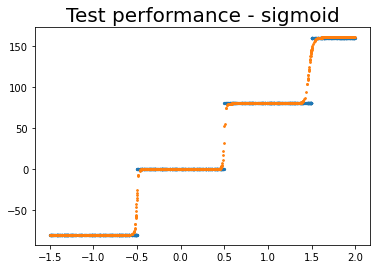

In [34]:
mymlp = generate_random_mlp([1,12,16,12,1], activation_function='sigmoid', output_function='linear')
mymlp.train(x_train, y_train, batch_size=128, epochs=1500, lr=0.0005)

result_sigmoid = mymlp.forward_prop(x_test)

plt.scatter(x=x_test, y=y_test, s=5)
plt.scatter(x=x_test, y=np.concatenate(result_sigmoid), s=3)
plt.title('Test performance - sigmoid', fontsize=20)

### 2.3.2 trzy warstwy ukryte - linear

Epoch: 0     Mean absolute error: 19.628206466096074
Epoch: 500   Mean absolute error: 19.318750880683517
Epoch: 1000  Mean absolute error: 19.315899054809144
Epoch: 1499  Mean absolute error: 19.314879012420477


Text(0.5, 1.0, 'Test performance - linear')

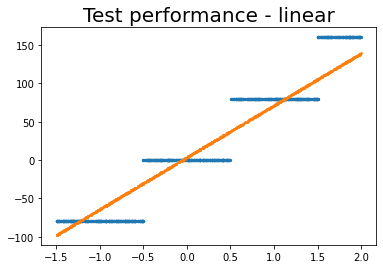

In [35]:
mymlp = generate_random_mlp([1,12,16,12,1], activation_function='linear', output_function='linear')
mymlp.train(x_train, y_train, batch_size=128, epochs=1500, lr=0.0005)

result_linear = mymlp.forward_prop(x_test)

plt.scatter(x=x_test, y=y_test, s=5)
plt.scatter(x=x_test, y=np.concatenate(result_linear), s=3)
plt.title('Test performance - linear', fontsize=20)

### 2.3.3 trzy warstwy ukryte - tanh

Epoch: 0     Mean absolute error: 52.186196032098586
Epoch: 500   Mean absolute error: 3.2763543057408375
Epoch: 1000  Mean absolute error: 3.5440388486876215
Epoch: 1499  Mean absolute error: 1.3487663773626206


Text(0.5, 1.0, 'Test performance - tanh')

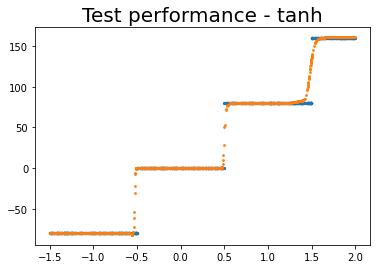

In [36]:
mymlp = generate_random_mlp([1,12,16,12,1], activation_function='tanh', output_function='linear')
mymlp.train(x_train, y_train, batch_size=128, epochs=1500, lr=0.0005)

result_tanh = mymlp.forward_prop(x_test)

plt.scatter(x=x_test, y=y_test, s=5)
plt.scatter(x=x_test, y=np.concatenate(result_tanh), s=3)
plt.title('Test performance - tanh', fontsize=20)

### 2.3.4 trzy warstwy ukryte - ReLU

Epoch: 0     Mean absolute error: 16.782991038674837
Epoch: 500   Mean absolute error: 3.405177851090112
Epoch: 1000  Mean absolute error: 4.7853335960293615
Epoch: 1499  Mean absolute error: 3.0569491992761346


Text(0.5, 1.0, 'Test performance')

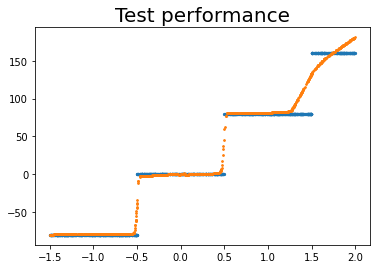

In [37]:
mymlp = generate_random_mlp([1,12,16,12,1], activation_function='ReLU', output_function='linear')
mymlp.train(x_train, y_train, batch_size=128, epochs=1500, lr=0.0005)

result_relu = mymlp.forward_prop(x_test)

plt.scatter(x=x_test, y=y_test, s=5)
plt.scatter(x=x_test, y=np.concatenate(result_relu), s=3)
plt.title('Test performance', fontsize=20)

### 2.3.5 podsumowanie zbioru - trzy warstwy ukryte

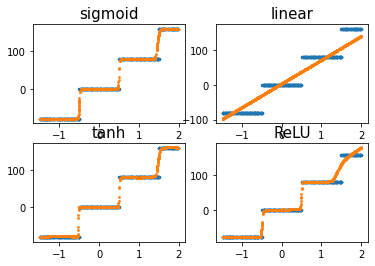

In [38]:
fig = plt.figure()

plt.subplot(2, 2, 1)
plt.scatter(x=x_test, y=y_test, s=5)
plt.scatter(x=x_test, y=np.concatenate(result_sigmoid), s=3)
plt.title('sigmoid', fontsize=15)

plt.subplot(2, 2, 2)
plt.scatter(x=x_test, y=y_test, s=5)
plt.scatter(x=x_test, y=np.concatenate(result_linear), s=3)
plt.title('linear', fontsize=15)

plt.subplot(2, 2, 3)
plt.scatter(x=x_test, y=y_test, s=5)
plt.scatter(x=x_test, y=np.concatenate(result_tanh), s=3)
plt.title('tanh', fontsize=15)

plt.subplot(2, 2, 4)
plt.scatter(x=x_test, y=y_test, s=5)
plt.scatter(x=x_test, y=np.concatenate(result_relu), s=3)
plt.title('ReLU', fontsize=15)

plt.show()

Znowu najlepsze są sigmoid oraz tanh, z nimi ReLU, a na końcu funkcja liniowa. 

# 3. Klasyfikacja: steps-large

In [39]:
train_df = pd.read_csv('~/Documents/Sem6/MIO/datasets/classification/rings5-regular-training.csv')
test_df = pd.read_csv('~/Documents/Sem6/MIO/datasets/classification/rings5-regular-test.csv')
train_df.iloc[0:6,:]

x          y  c
0  26.926121 -16.588451  0
1 -77.438767  95.159464  0
2 -98.650099  94.923714  0
3  22.241184  -5.447678  0
4  12.843637 -21.496457  0
5  23.856256 -26.131078  0

Text(0.5, 1.0, 'Train dataset')

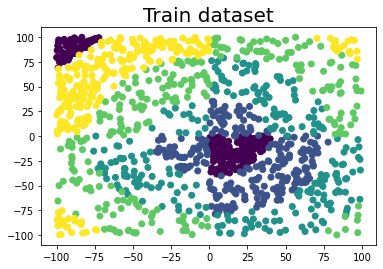

In [40]:
plt.scatter(train_df['x'], train_df['y'], c=train_df['c'])
plt.title('Train dataset', fontsize=20)

#### skalowanie danych

In [41]:
x_train = np.asarray(train_df.iloc[:,0:2])
x_train = (x_train - np.mean(x_train, axis = 0))/np.std(x_train, axis = 0)

x_test = np.asarray(test_df.iloc[:,0:2])
x_test = (x_test - np.mean(x_test, axis = 0))/np.std(x_test, axis = 0)

y_train = np.asarray(train_df.iloc[:,2]).reshape(-1, 1)

## 3.1 jedna warstwa ukryta

### 3.1.1 jedna warstwa ukryta - sigmoid

Epoch: 0     Cross entropy loss: 5.317518608229164
Epoch: 500   Cross entropy loss: 3.119421279611525
Epoch: 1000  Cross entropy loss: 3.1342103510999664
Epoch: 1500  Cross entropy loss: 3.1279150991902056
Epoch: 2000  Cross entropy loss: 3.112594062439895
Epoch: 2500  Cross entropy loss: 3.092733600202129
Epoch: 2999  Cross entropy loss: 3.069586059363964


Text(0.5, 1.0, 'rings5-regular, sigmoid')

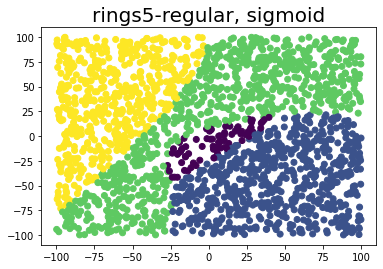

In [42]:
mymlp = generate_random_mlp([2,100,5], activation_function='sigmoid', output_function='softmax')
mymlp.train(x_train, y_train, batch_size=128, epochs=3000, lr=0.01)

result_sigmoid = mymlp.forward_prop(x_test)

result_sigmoid = np.argmax(result_sigmoid, axis = 1)
plt.scatter(test_df['x'], test_df['y'], c=result_sigmoid)
plt.title("rings5-regular, sigmoid", size=20)

### 3.1.2 jedna warstwa ukryta - linear

Epoch: 0     Cross entropy loss: 4.924368759889467
Epoch: 500   Cross entropy loss: 2.7617451503201793
Epoch: 1000  Cross entropy loss: 2.8380051726265934
Epoch: 1500  Cross entropy loss: 2.8508943562575664
Epoch: 2000  Cross entropy loss: 2.8264259406005383
Epoch: 2500  Cross entropy loss: 2.7545885919355655
Epoch: 2999  Cross entropy loss: 2.5598423279573006


Text(0.5, 1.0, 'rings5-regular, linear')

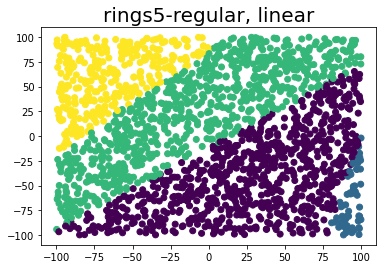

In [43]:
mymlp = generate_random_mlp([2,100,5], activation_function='linear', output_function='softmax')
mymlp.train(x_train, y_train, batch_size=128, epochs=3000, lr=0.01)

result_linear = mymlp.forward_prop(x_test)

result_linear = np.argmax(result_linear, axis = 1)
plt.scatter(test_df['x'], test_df['y'], c=result_linear)
plt.title("rings5-regular, linear", size=20)

### 3.1.3 jedna warstwa ukryta - tanh

Epoch: 0     Cross entropy loss: 3.8418298024227377
Epoch: 500   Cross entropy loss: 1.3087387154297765
Epoch: 1000  Cross entropy loss: 1.070454019311584
Epoch: 1500  Cross entropy loss: 1.042386818637541
Epoch: 2000  Cross entropy loss: 1.0345872449916687
Epoch: 2500  Cross entropy loss: 1.0344820525990892
Epoch: 2999  Cross entropy loss: 1.039339688690763


Text(0.5, 1.0, 'rings5-regular, tanh')

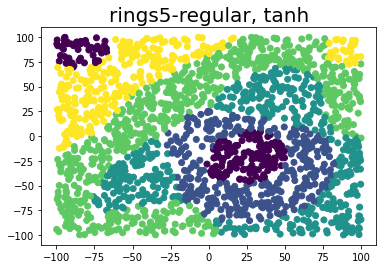

In [44]:
mymlp = generate_random_mlp([2,100,5], activation_function='tanh', output_function='softmax')
mymlp.train(x_train, y_train, batch_size=128, epochs=3000, lr=0.01)

result_tanh = mymlp.forward_prop(x_test)

result_tanh = np.argmax(result_tanh, axis = 1)
plt.scatter(test_df['x'], test_df['y'], c=result_tanh)
plt.title("rings5-regular, tanh", size=20)

### 3.1.4 jedna warstwa ukryta - ReLU

Epoch: 0     Cross entropy loss: 2.9407282276875493
Epoch: 500   Cross entropy loss: 0.8584615063731165
Epoch: 1000  Cross entropy loss: 0.7166798203313046
Epoch: 1500  Cross entropy loss: 0.6359616284646088
Epoch: 2000  Cross entropy loss: 0.5888447377420479
Epoch: 2500  Cross entropy loss: 0.5560236151850992
Epoch: 2999  Cross entropy loss: 0.5300143247234247


Text(0.5, 1.0, 'rings5-regular, linear')

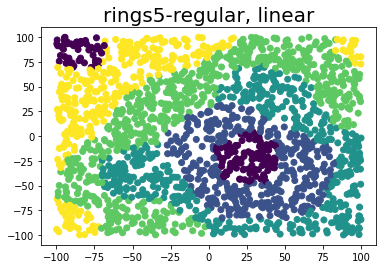

In [45]:
mymlp = generate_random_mlp([2,100,5], activation_function='ReLU', output_function='softmax')
mymlp.train(x_train, y_train, batch_size=128, epochs=3000, lr=0.01)

result_relu = mymlp.forward_prop(x_test)

result_relu = np.argmax(result_relu, axis = 1)
plt.scatter(test_df['x'], test_df['y'], c=result_relu)
plt.title("rings5-regular, linear", size=20)

### 3.1.5 Podsumowanie zbioru - jedna warstwa ukryta

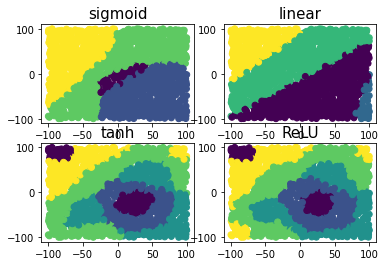

In [46]:
fig = plt.figure()

plt.subplot(2, 2, 1)
plt.scatter(test_df['x'], test_df['y'], c=result_sigmoid)
plt.title('sigmoid', fontsize=15)

plt.subplot(2, 2, 2)
plt.scatter(test_df['x'], test_df['y'], c=result_linear)
plt.title('linear', fontsize=15)

plt.subplot(2, 2, 3)
plt.scatter(test_df['x'], test_df['y'], c=result_tanh)
plt.title('tanh', fontsize=15)

plt.subplot(2, 2, 4)
plt.scatter(test_df['x'], test_df['y'], c=result_relu)
plt.title('ReLU', fontsize=15)

plt.show()

Dla jednej warstwy najlepsze okazały się tanh oraz ReLU - widzoczne stają się już pierścienie.

## 3.2 dwie warstwy ukryte

### 3.2.1 dwie warstwy ukryte - sigmoid

Epoch: 0     Cross entropy loss: 5.072586208986766
Epoch: 500   Cross entropy loss: 1.2984095281302812
Epoch: 1000  Cross entropy loss: 1.1994110530263313
Epoch: 1500  Cross entropy loss: 1.1267385687642824
Epoch: 1999  Cross entropy loss: 1.0679048686008714


Text(0.5, 1.0, 'rings5-regular, sigmoid')

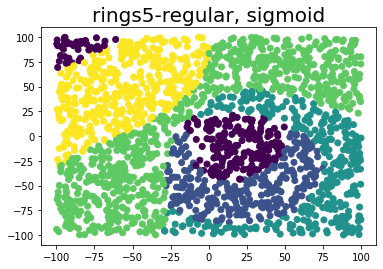

In [47]:
mymlp = generate_random_mlp([2,100,100,5], activation_function='sigmoid', output_function='softmax')
mymlp.train(x_train, y_train, batch_size=128, epochs=2000, lr=0.01)

result_sigmoid = mymlp.forward_prop(x_test)

result_sigmoid = np.argmax(result_sigmoid, axis = 1)
plt.scatter(test_df['x'], test_df['y'], c=result_sigmoid)
plt.title("rings5-regular, sigmoid", size=20)

### 3.2.2 dwie warstwy ukryte - linear

Epoch: 0     Cross entropy loss: 21.10476692031925
Epoch: 500   Cross entropy loss: 5.826819703996383
Epoch: 1000  Cross entropy loss: 2.635662607706312
Epoch: 1500  Cross entropy loss: 1.9101298489280614
Epoch: 1999  Cross entropy loss: 1.8898727875025885


Text(0.5, 1.0, 'rings5-regular, linear')

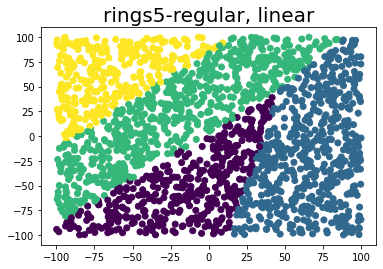

In [48]:
mymlp = generate_random_mlp([2,100,100,5], activation_function='linear', output_function='softmax')
mymlp.train(x_train, y_train, batch_size=128, epochs=2000, lr=0.01)

result_linear = mymlp.forward_prop(x_test)

result_linear = np.argmax(result_linear, axis = 1)
plt.scatter(test_df['x'], test_df['y'], c=result_linear)
plt.title("rings5-regular, linear", size=20)

### 3.2.3 dwie warstwy ukryte - tanh

Epoch: 0     Cross entropy loss: 5.066155758672487
Epoch: 500   Cross entropy loss: 1.5141751197674895
Epoch: 1000  Cross entropy loss: 1.4787483580310075
Epoch: 1500  Cross entropy loss: 1.4631645561514988
Epoch: 1999  Cross entropy loss: 1.466313872271865


Text(0.5, 1.0, 'rings5-regular, tanh')

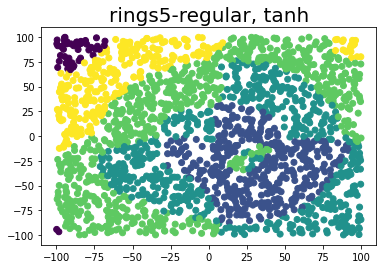

In [49]:
mymlp = generate_random_mlp([2,100,100,5], activation_function='tanh', output_function='softmax')
mymlp.train(x_train, y_train, batch_size=128, epochs=2000, lr=0.01)

result_tanh = mymlp.forward_prop(x_test)

result_tanh = np.argmax(result_tanh, axis = 1)
plt.scatter(test_df['x'], test_df['y'], c=result_tanh)
plt.title("rings5-regular, tanh", size=20)

### 3.2.4  dwie warstwy ukryte - ReLU

Epoch: 0     Cross entropy loss: 12.24809622102801
Epoch: 500   Cross entropy loss: 8.181041543165616
Epoch: 1000  Cross entropy loss: 8.287489740295799
Epoch: 1500  Cross entropy loss: 8.344309781368317
Epoch: 1999  Cross entropy loss: 8.406861534008177


Text(0.5, 1.0, 'rings5-regular, ReLU')

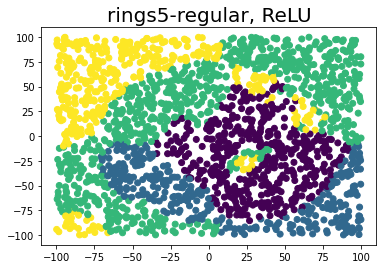

In [50]:
mymlp = generate_random_mlp([2,100,100,5], activation_function='ReLU', output_function='softmax')
mymlp.train(x_train, y_train, batch_size=128, epochs=2000, lr=0.01)

result_relu = mymlp.forward_prop(x_test)

result_relu = np.argmax(result_relu, axis = 1)
plt.scatter(test_df['x'], test_df['y'], c=result_relu)
plt.title("rings5-regular, ReLU", size=20)

### 3.2.5 podsumowanie zbioru - dwie warstwy ukryte

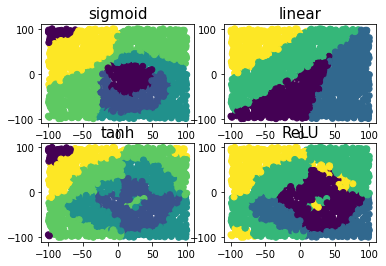

In [51]:
fig = plt.figure()

plt.subplot(2, 2, 1)
plt.scatter(test_df['x'], test_df['y'], c=result_sigmoid)
plt.title('sigmoid', fontsize=15)

plt.subplot(2, 2, 2)
plt.scatter(test_df['x'], test_df['y'], c=result_linear)
plt.title('linear', fontsize=15)

plt.subplot(2, 2, 3)
plt.scatter(test_df['x'], test_df['y'], c=result_tanh)
plt.title('tanh', fontsize=15)

plt.subplot(2, 2, 4)
plt.scatter(test_df['x'], test_df['y'], c=result_relu)
plt.title('ReLU', fontsize=15)

plt.show()

Najlpesze są tanh oraz ReLU, również w przypadku sigmoida pojawiają się pierścienie.

## 3.3 trzy warstwy ukryte

### 3.3.1 trzy warstwy ukryte - sigmoid

Epoch: 0     Cross entropy loss: 4.315065606077281
Epoch: 500   Cross entropy loss: 3.4835045105576494
Epoch: 1000  Cross entropy loss: 3.394259522735639
Epoch: 1499  Cross entropy loss: 3.3021134133746144


Text(0.5, 1.0, 'rings5-regular, sigmoid')

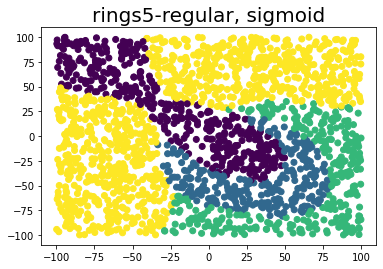

In [52]:
mymlp = generate_random_mlp([2,100,100,100,5], activation_function='sigmoid', output_function='softmax')
mymlp.train(x_train, y_train, batch_size=128, epochs=1500, lr=0.01)

result_sigmoid = mymlp.forward_prop(x_test)

result_sigmoid = np.argmax(result_sigmoid, axis = 1)
plt.scatter(test_df['x'], test_df['y'], c=result_sigmoid)
plt.title("rings5-regular, sigmoid", size=20)

### 3.3.2 trzy warstwy ukryte - linear

Epoch: 0     Cross entropy loss: 29.602887006699095
Epoch: 500   Cross entropy loss: 23.971224378035583
Epoch: 1000  Cross entropy loss: 20.23440802899475
Epoch: 1499  Cross entropy loss: 20.10378046902758


Text(0.5, 1.0, 'rings5-regular, linear')

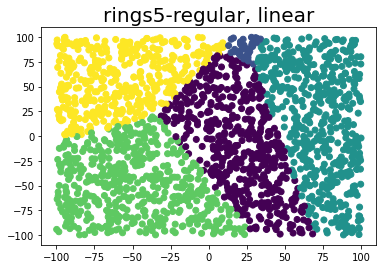

In [53]:
mymlp = generate_random_mlp([2,100,100,100,5], activation_function='linear', output_function='softmax')
mymlp.train(x_train, y_train, batch_size=128, epochs=1500, lr=0.01)

result_linear = mymlp.forward_prop(x_test)

result_linear = np.argmax(result_linear, axis = 1)
plt.scatter(test_df['x'], test_df['y'], c=result_linear)
plt.title("rings5-regular, linear", size=20)

### 3.3.3 trzy warstwy ukryte - tanh

Epoch: 0     Cross entropy loss: 5.146442856529069
Epoch: 500   Cross entropy loss: 0.4834513017135619
Epoch: 1000  Cross entropy loss: 0.1208770902273351
Epoch: 1499  Cross entropy loss: 0.09501125640288366


Text(0.5, 1.0, 'rings5-regular, tanh')

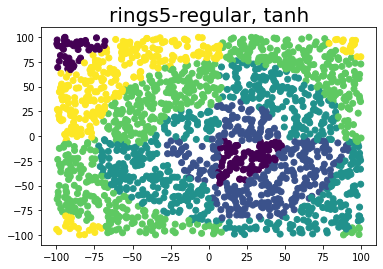

In [54]:
mymlp = generate_random_mlp([2,100,100,100,5], activation_function='tanh', output_function='softmax')
mymlp.train(x_train, y_train, batch_size=128, epochs=1500, lr=0.01)

result_tanh = mymlp.forward_prop(x_test)

result_tanh = np.argmax(result_tanh, axis = 1)
plt.scatter(test_df['x'], test_df['y'], c=result_tanh)
plt.title("rings5-regular, tanh", size=20)

### 3.3.4 trzy warstwy ukryte - ReLU

Epoch: 0     Cross entropy loss: 25.88528989589695
Epoch: 500   Cross entropy loss: 18.555804634360786
Epoch: 1000  Cross entropy loss: 14.376417281629038
Epoch: 1499  Cross entropy loss: 14.128370337551047


Text(0.5, 1.0, 'rings5-regular, linear')

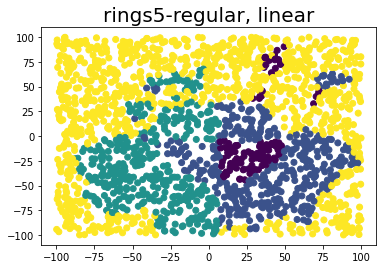

In [55]:
mymlp = generate_random_mlp([2,100,100,100,5], activation_function='ReLU', output_function='softmax')
mymlp.train(x_train, y_train, batch_size=128, epochs=1500, lr=0.01)

result_relu = mymlp.forward_prop(x_test)

result_relu = np.argmax(result_relu, axis = 1)
plt.scatter(test_df['x'], test_df['y'], c=result_relu)
plt.title("rings5-regular, linear", size=20)

### 3.3.5 Posumowanie zbioru - trzy warstwy ukryte

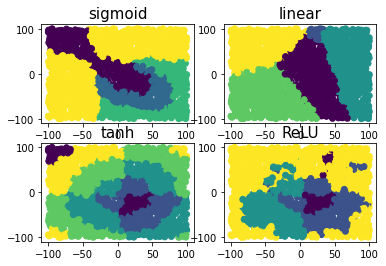

In [56]:
fig = plt.figure()

plt.subplot(2, 2, 1)
plt.scatter(test_df['x'], test_df['y'], c=result_sigmoid)
plt.title('sigmoid', fontsize=15)

plt.subplot(2, 2, 2)
plt.scatter(test_df['x'], test_df['y'], c=result_linear)
plt.title('linear', fontsize=15)

plt.subplot(2, 2, 3)
plt.scatter(test_df['x'], test_df['y'], c=result_tanh)
plt.title('tanh', fontsize=15)

plt.subplot(2, 2, 4)
plt.scatter(test_df['x'], test_df['y'], c=result_relu)
plt.title('ReLU', fontsize=15)

plt.show()

Przy trzech warstwach znacznie lepiej od innych funkcji dopasował się tanh, sądząc po spadku błędu, przy większej liczbie epok, mógłby dopasować się nawet lepiej.

W żadnym przypadku, sieć nie nauczyła się zbioru.

# 4. Klasyfikacja: rings3-regular

In [57]:
train_df = pd.read_csv('~/Documents/Sem6/MIO/datasets/classification/rings3-regular-training.csv')
test_df = pd.read_csv('~/Documents/Sem6/MIO/datasets/classification/rings3-regular-test.csv')
train_df.iloc[0:6,:]

x          y  c
0 -93.563317 -76.345110  0
1   1.060114 -16.727040  0
2  24.396099  40.358822  0
3 -94.595137 -97.889250  0
4 -85.331382 -56.736933  0
5  26.449775  18.969033  0

Text(0.5, 1.0, 'Train dataset')

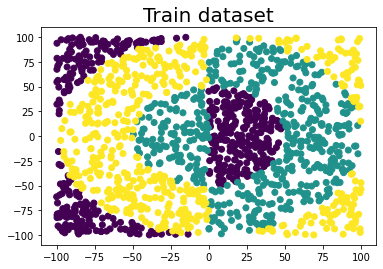

In [58]:
plt.scatter(train_df['x'], train_df['y'], c=train_df['c'])
plt.title('Train dataset', fontsize=20)

#### skalowanie danych

In [59]:
x_train = np.asarray(train_df.iloc[:,0:2])
x_train = (x_train - np.mean(x_train, axis = 0))/np.std(x_train, axis = 0)

x_test = np.asarray(test_df.iloc[:,0:2])
x_test = (x_test - np.mean(x_test, axis = 0))/np.std(x_test, axis = 0)

y_train = np.asarray(train_df.iloc[:,2]).reshape(-1, 1)

## 4.1 jedna warstwa ukryta

### 4.1.1 jedna warstwa ukryta - sigmoid

Epoch: 0     Cross entropy loss: 1.2885274768343995
Epoch: 500   Cross entropy loss: 0.8903864189528568
Epoch: 1000  Cross entropy loss: 0.7782861737667401
Epoch: 1500  Cross entropy loss: 0.6919093096872694
Epoch: 2000  Cross entropy loss: 0.5911801567266679
Epoch: 2500  Cross entropy loss: 0.5062204147538824
Epoch: 2999  Cross entropy loss: 0.44475181312694945


Text(0.5, 1.0, 'rings3-regular, sigmoid')

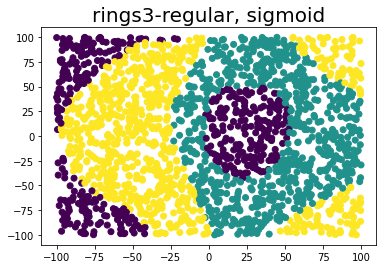

In [60]:
mymlp = generate_random_mlp([2,100,3], activation_function='sigmoid', output_function='softmax')
mymlp.train(x_train, y_train, batch_size=32, epochs=3000, lr=0.01)

result_sigmoid = mymlp.forward_prop(x_test)

result_sigmoid = np.argmax(result_sigmoid, axis = 1)
plt.scatter(test_df['x'], test_df['y'], c=result_sigmoid)
plt.title("rings3-regular, sigmoid", size=20)

### 4.1.2 jedna warstwa ukryta - linear

Epoch: 0     Cross entropy loss: 5.532005467613193
Epoch: 500   Cross entropy loss: 0.9465565441891408
Epoch: 1000  Cross entropy loss: 0.946546939054727
Epoch: 1500  Cross entropy loss: 0.9465372752854446
Epoch: 2000  Cross entropy loss: 0.9465275548853008
Epoch: 2500  Cross entropy loss: 0.9465177798340869
Epoch: 2999  Cross entropy loss: 0.9465079717940681


Text(0.5, 1.0, 'rings3-regular, linear')

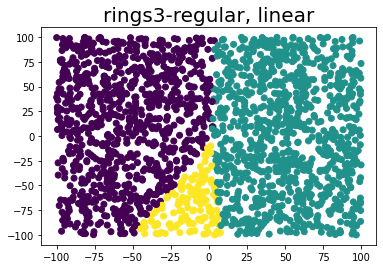

In [61]:
mymlp = generate_random_mlp([2,100,3], activation_function='linear', output_function='softmax')
mymlp.train(x_train, y_train, batch_size=32, epochs=3000, lr=0.01)

result_linear = mymlp.forward_prop(x_test)

result_linear = np.argmax(result_linear, axis = 1)
plt.scatter(test_df['x'], test_df['y'], c=result_linear)
plt.title("rings3-regular, linear", size=20)

### 4.1.3 jedna warstwa ukryta - tanh

Epoch: 0     Cross entropy loss: 1.5383118047915507
Epoch: 500   Cross entropy loss: 2.4473436705293063
Epoch: 1000  Cross entropy loss: 2.803257978828688
Epoch: 1500  Cross entropy loss: 3.061735676993848
Epoch: 2000  Cross entropy loss: 3.229658589082604
Epoch: 2500  Cross entropy loss: 3.3213810332429334
Epoch: 2999  Cross entropy loss: 3.3654183013674435


Text(0.5, 1.0, 'rings3-regular, tanh')

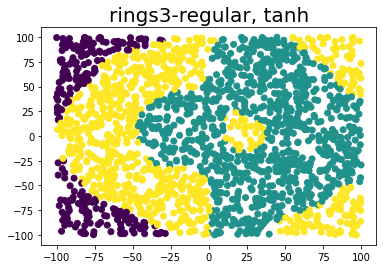

In [62]:
mymlp = generate_random_mlp([2,100,3], activation_function='tanh', output_function='softmax')
mymlp.train(x_train, y_train, batch_size=32, epochs=3000, lr=0.01)

result_tanh = mymlp.forward_prop(x_test)

result_tanh = np.argmax(result_tanh, axis = 1)
plt.scatter(test_df['x'], test_df['y'], c=result_tanh)
plt.title("rings3-regular, tanh", size=20)

### 4.1.4 jedna warstwa ukryta - ReLU

Epoch: 0     Cross entropy loss: 3.844948871598444
Epoch: 500   Cross entropy loss: 0.7065231802028593
Epoch: 1000  Cross entropy loss: 0.6919288037827809
Epoch: 1500  Cross entropy loss: 0.6914522767401288
Epoch: 2000  Cross entropy loss: 0.6907562424247365
Epoch: 2500  Cross entropy loss: 0.6945608231933259
Epoch: 2999  Cross entropy loss: 0.7066308460984195


Text(0.5, 1.0, 'rings3-regular, ReLU')

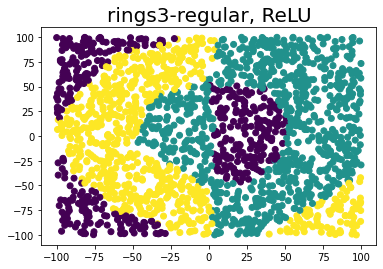

In [63]:
mymlp = generate_random_mlp([2,100,3], activation_function='ReLU', output_function='softmax')
mymlp.train(x_train, y_train, batch_size=32, epochs=3000, lr=0.01)

result_relu = mymlp.forward_prop(x_test)

result_relu = np.argmax(result_relu, axis = 1)
plt.scatter(test_df['x'], test_df['y'], c=result_relu)
plt.title("rings3-regular, ReLU", size=20)

### 4.1.5 Podsumownie zbioru - jedna warstwa ukryta

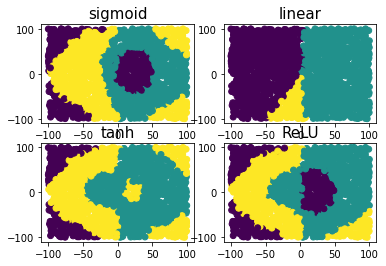

In [64]:
fig = plt.figure()

plt.subplot(2, 2, 1)
plt.scatter(test_df['x'], test_df['y'], c=result_sigmoid)
plt.title('sigmoid', fontsize=15)

plt.subplot(2, 2, 2)
plt.scatter(test_df['x'], test_df['y'], c=result_linear)
plt.title('linear', fontsize=15)

plt.subplot(2, 2, 3)
plt.scatter(test_df['x'], test_df['y'], c=result_tanh)
plt.title('tanh', fontsize=15)

plt.subplot(2, 2, 4)
plt.scatter(test_df['x'], test_df['y'], c=result_relu)
plt.title('ReLU', fontsize=15)

plt.show()

Wszystkie funkcje poza liniową radzą sobie dobrze, już dla pojedynczej warstwy ukrytej.

## 4.2 dwie warstwy ukryte

### 4.2.1 dwie warstwy ukryte - sigmoid

Epoch: 0     Cross entropy loss: 4.287595482120877
Epoch: 500   Cross entropy loss: 0.5899339380860678
Epoch: 1000  Cross entropy loss: 0.3799670492356671
Epoch: 1500  Cross entropy loss: 0.2972118422922839
Epoch: 1999  Cross entropy loss: 0.2505912451901186


Text(0.5, 1.0, 'rings3-regular, sigmoid')

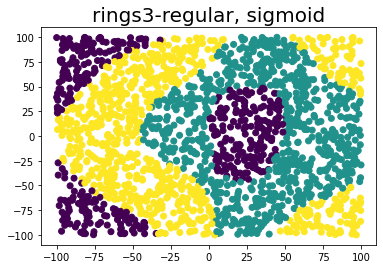

In [65]:
mymlp = generate_random_mlp([2,100,100,3], activation_function='sigmoid', output_function='softmax')
mymlp.train(x_train, y_train, batch_size=32, epochs=2000, lr=0.01)

result_sigmoid = mymlp.forward_prop(x_test)

result_sigmoid = np.argmax(result_sigmoid, axis = 1)
plt.scatter(test_df['x'], test_df['y'], c=result_sigmoid)
plt.title("rings3-regular, sigmoid", size=20)

### 4.2.2 dwie warstwy ukryte - linear

Epoch: 0     Cross entropy loss: 18.670509673296323
Epoch: 500   Cross entropy loss: 7.733514137373777
Epoch: 1000  Cross entropy loss: 4.901497712536424
Epoch: 1500  Cross entropy loss: 2.988647674309609
Epoch: 1999  Cross entropy loss: 2.3621987198633803


Text(0.5, 1.0, 'rings3-regular, linear')

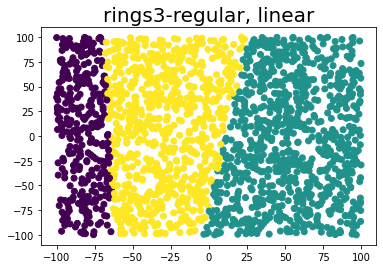

In [66]:
mymlp = generate_random_mlp([2,100,100,3], activation_function='linear', output_function='softmax')
mymlp.train(x_train, y_train, batch_size=32, epochs=2000, lr=0.01)

result_linear = mymlp.forward_prop(x_test)

result_linear = np.argmax(result_linear, axis = 1)
plt.scatter(test_df['x'], test_df['y'], c=result_linear)
plt.title("rings3-regular, linear", size=20)

### 4.2.3 dwie warstwy ukryte - tanh

Epoch: 0     Cross entropy loss: 2.4312448994363716
Epoch: 500   Cross entropy loss: 0.06476838298922619
Epoch: 1000  Cross entropy loss: 0.04517249889401887
Epoch: 1500  Cross entropy loss: 0.03590225502697107
Epoch: 1999  Cross entropy loss: 0.030047258049584153


Text(0.5, 1.0, 'rings3-regular, tanh')

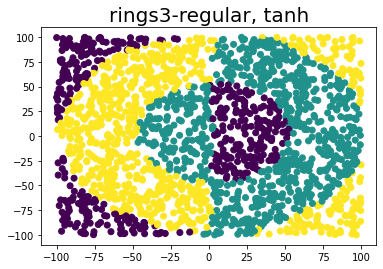

In [67]:
mymlp = generate_random_mlp([2,100,100,3], activation_function='tanh', output_function='softmax')
mymlp.train(x_train, y_train, batch_size=32, epochs=2000, lr=0.01)

result_tanh = mymlp.forward_prop(x_test)

result_tanh = np.argmax(result_tanh, axis = 1)
plt.scatter(test_df['x'], test_df['y'], c=result_tanh)
plt.title("rings3-regular, tanh", size=20)

### 4.2.4 dwie warstwy ukryte - ReLU

Epoch: 0     Cross entropy loss: 9.158049757688193
Epoch: 500   Cross entropy loss: 4.428592087765931
Epoch: 1000  Cross entropy loss: 1.1066833004412302
Epoch: 1500  Cross entropy loss: 1.2862782585007746
Epoch: 1999  Cross entropy loss: 1.2741277554620714


Text(0.5, 1.0, 'rings3-regular, ReLU')

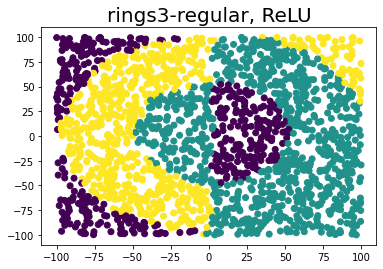

In [68]:
mymlp = generate_random_mlp([2,100,100,3], activation_function='ReLU', output_function='softmax')
mymlp.train(x_train, y_train, batch_size=32, epochs=2000, lr=0.01)

result_relu = mymlp.forward_prop(x_test)

result_relu = np.argmax(result_relu, axis = 1)
plt.scatter(test_df['x'], test_df['y'], c=result_relu)
plt.title("rings3-regular, ReLU", size=20)

### 4.2.5 Podsumowanie zbioru - dwie warstwy ukryte

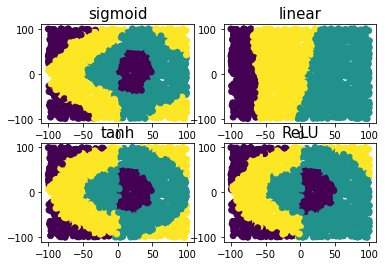

In [69]:
fig = plt.figure()

plt.subplot(2, 2, 1)
plt.scatter(test_df['x'], test_df['y'], c=result_sigmoid)
plt.title('sigmoid', fontsize=15)

plt.subplot(2, 2, 2)
plt.scatter(test_df['x'], test_df['y'], c=result_linear)
plt.title('linear', fontsize=15)

plt.subplot(2, 2, 3)
plt.scatter(test_df['x'], test_df['y'], c=result_tanh)
plt.title('tanh', fontsize=15)

plt.subplot(2, 2, 4)
plt.scatter(test_df['x'], test_df['y'], c=result_relu)
plt.title('ReLU', fontsize=15)

plt.show()

Przy dwóch warstwach ukrytych, najlepszy jest tanh, który już osiąga bardzo dobre dopasowanie, za nim ReLU, a następnie sigmoid

## 4.3 Trzy warstwy ukryte

### 4.3.1 Trzy warstwy ukryte - sigmoid

Epoch: 0     Cross entropy loss: 2.7227713232892143
Epoch: 500   Cross entropy loss: 0.431644534365372
Epoch: 1000  Cross entropy loss: 0.2707905313132628
Epoch: 1499  Cross entropy loss: 0.20431420074165332


Text(0.5, 1.0, 'rings3-regular, linear')

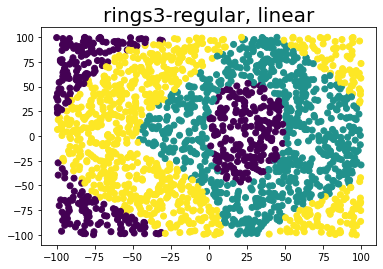

In [72]:
mymlp = generate_random_mlp([2,100,100,100,3], activation_function='sigmoid', output_function='softmax')
mymlp.train(x_train, y_train, batch_size=32, epochs=1500, lr=0.01)

result_sigmoid = mymlp.forward_prop(x_test)

result_sigmoid = np.argmax(result_sigmoid, axis = 1)
plt.scatter(test_df['x'], test_df['y'], c=result_sigmoid)
plt.title("rings3-regular, linear", size=20)

### 4.3.2 Trzy warstwy ukryte - linear

Epoch: 0     Cross entropy loss: 29.604665481352015
Epoch: 500   Cross entropy loss: 20.970641878010976
Epoch: 1000  Cross entropy loss: 20.97063798939265
Epoch: 1499  Cross entropy loss: 20.9703987510311


Text(0.5, 1.0, 'rings3-regular, linear')

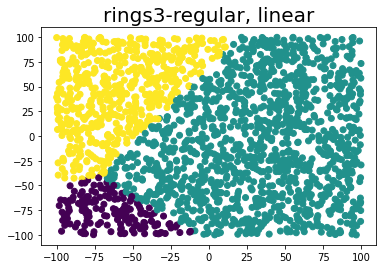

In [73]:
mymlp = generate_random_mlp([2,100,100,100,3], activation_function='linear', output_function='softmax')
mymlp.train(x_train, y_train, batch_size=32, epochs=1500, lr=0.01)

result_linear = mymlp.forward_prop(x_test)

result_linear = np.argmax(result_linear, axis = 1)
plt.scatter(test_df['x'], test_df['y'], c=result_linear)
plt.title("rings3-regular, linear", size=20)

### 4.3.3 Trzy warstwy ukryte - tanh

Epoch: 0     Cross entropy loss: 4.6334785727172525
Epoch: 500   Cross entropy loss: 0.006814188218062551
Epoch: 1000  Cross entropy loss: 0.0036257448071068785
Epoch: 1499  Cross entropy loss: 0.0024958858807550026


Text(0.5, 1.0, 'rings3-regular, tanh')

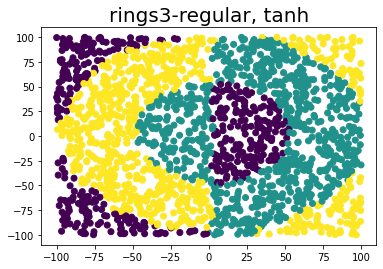

In [74]:
mymlp = generate_random_mlp([2,100,100,100,3], activation_function='tanh', output_function='softmax')
mymlp.train(x_train, y_train, batch_size=32, epochs=1500, lr=0.01)

result_tanh = mymlp.forward_prop(x_test)

result_tanh = np.argmax(result_tanh, axis = 1)
plt.scatter(test_df['x'], test_df['y'], c=result_tanh)
plt.title("rings3-regular, tanh", size=20)

### 4.3.4 Trzy warstwy ukryte - ReLU

Epoch: 0     Cross entropy loss: 18.353396376278944
Epoch: 500   Cross entropy loss: 16.0358632110996
Epoch: 1000  Cross entropy loss: 16.03586323524701
Epoch: 1499  Cross entropy loss: 16.035861120663913


Text(0.5, 1.0, 'rings3-regular, linear')

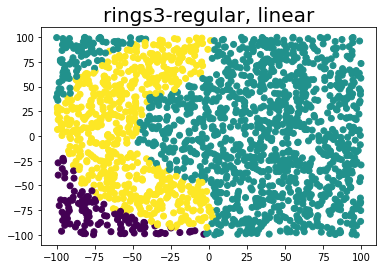

In [75]:
mymlp = generate_random_mlp([2,100,100,100,3], activation_function='ReLU', output_function='softmax')
mymlp.train(x_train, y_train, batch_size=32, epochs=1500, lr=0.01)

result_relu = mymlp.forward_prop(x_test)

result_relu = np.argmax(result_relu, axis = 1)
plt.scatter(test_df['x'], test_df['y'], c=result_relu)
plt.title("rings3-regular, linear", size=20)

### 4.3.5 podsumowanie zbioru - trzy warstwy ukryte

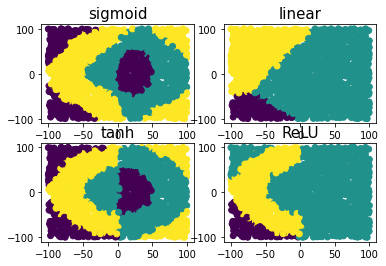

In [76]:
fig = plt.figure()

plt.subplot(2, 2, 1)
plt.scatter(test_df['x'], test_df['y'], c=result_sigmoid)
plt.title('sigmoid', fontsize=15)

plt.subplot(2, 2, 2)
plt.scatter(test_df['x'], test_df['y'], c=result_linear)
plt.title('linear', fontsize=15)

plt.subplot(2, 2, 3)
plt.scatter(test_df['x'], test_df['y'], c=result_tanh)
plt.title('tanh', fontsize=15)

plt.subplot(2, 2, 4)
plt.scatter(test_df['x'], test_df['y'], c=result_relu)
plt.title('ReLU', fontsize=15)

plt.show()

tanh dopasował się bardzo dobrze, tym razem ReLU gorzej niż w przypadku dwóch warst ukrytych, sigmoid nadal słabiej.

# 5. Wnioski
    - dla problemu regresji najlepiej sprawdza się funckja sigmoid oraz tanh,
    - dla problemu klasyfikacji najleiej sprawdza się tangens hiperboliczny, dla obu zbiorów dawał on lepsze wyniki, w porównaniu do innych funkcji.
    - funkcja liniowa nie nadaje się do tego typu zadań, ze względu na to że wyjście zawsze będzie liniową funkcją wejścia.
    - W przypadku konieczności wyboru wspólnej funkcji zarówno dla problemu regresji jak i klasyfikacji, najlepszą opcją jest zdecydowanie tangens hiperboliczny.
    - zachowanie funkcji ReLU wydaje się dosyć niestabilne - w jednym przypadku dla regresji jakość predykcji bradzo zmalała w ciągu ostatnich 500 epok, natomiast w jednym przypadku w klasyfikacji, sięć z dodatkową warstwą poradziła sobie znacznie gorzej (chociaż to może być zależne od początkowych, losowych wag)